# Chess Game Analysis vs. Engine

In [1]:
import pandas as pd
import numpy as np

import chess.pgn
import chess
import io

sf = "/home/robmulla/Downloads/stockfish_15_linux_x64/stockfish_15_src/src/stockfish"
from stockfish import Stockfish

pd.set_option('display.max_columns', 500)

In [2]:
%load_ext lab_black

## Check out the SUS Game

In [3]:
df = pd.read_parquet("games/Niemann.parquet")
df = df.drop_duplicates().reset_index(drop=True)
df["Round"] = df["Round"].astype("float")

In [4]:
# Sus games?

In [5]:
(df.Date_clean.dt.year == 2021).sum()

382

In [6]:
sus_game = df.loc[
    df["Event"].str.contains("Shar")
    & (df["Round"] == 2)
    & (df.Date_clean.dt.year == 2021)
]

In [7]:
pgn = io.StringIO(sus_game["mainline_moves"].values[0])
game = chess.pgn.read_game(pgn)
game.board()

idx = 1
stop_move = 21

board = game.board()
for move in game.mainline_moves():
    board.push(move)
    idx += 1
    if idx == stop_move:
        break

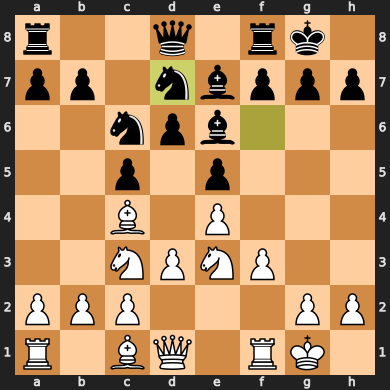

In [8]:
board

In [9]:
stockfish = Stockfish(
    path=sf,
    depth=12,
    parameters={
        "Threads": 16,
        "Minimum Thinking Time": 30,
    },
)

stockfish.set_fen_position(board.fen)
stockfish.get_top_moves()

StockfishException: The Stockfish process has crashed

In [ ]:
def get_game_corr(game, playing_as):
    board = game.board()

    engine_cps = []
    played_cps = []
    top_moves = []
    played_moves = []
    for move in game.mainline_moves():

        if playing_as == "White" and board.turn == True:
            stockfish.set_fen_position(board.fen())
            top = stockfish.get_top_moves(10)
            best_move = top[0]["Move"]
            best_centipawn = top[0]["Centipawn"]
            # White's move
            board.push(move)
            evaluation = stockfish.get_evaluation()["value"]
            # print(f"{best_move}: {best_centipawn} - {move}: {evaluation}")
            top_moves.append(top)
            engine_cps.append(best_centipawn)
            played_cps.append(evaluation)
            played_moves.append(move)

        elif playing_as == "Black" and board.turn == False:
            # black's move
            stockfish.set_fen_position(board.fen())
            top = stockfish.get_top_moves(10)
            best_move = top[0]["Move"]
            best_centipawn = top[0]["Centipawn"]
            board.push(move)
            evaluation = stockfish.get_evaluation()["value"]
            # print(f"{best_move}: {best_centipawn} - {move}: {evaluation}")
            top_moves.append(top)
            engine_cps.append(best_centipawn)
            played_cps.append(evaluation)
            played_moves.append(move)
        else:
            board.push(move)
    corr = np.corrcoef([engine_cps, played_cps])[1, 0]
    return top_moves, played_moves, engine_cps, played_cps, corr